# Soft whitening

Demonstrate a case where the algorithm whitens as much as it can with a non-negative constraint on g.

In [34]:
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy as sp
import seaborn as sns

import frame_whitening as fw
from frame_whitening.types import FuncType
import frame_whitening.simulation as fwsim
import frame_whitening.plot as fwplt

os.chdir(os.path.expanduser("~/frame_whitening"))
print(os.getcwd())

/mnt/home/lduong/frame_whitening


## Define a Cxx whose condition number is known to require negative g to whiten

In [6]:
seed = 42069
np.random.seed(seed)
batch_size = 256
n_batch = 10000
lr_g = 5e-4
n = 2

Q = fw.rot2(np.deg2rad(35))
kappa = 15
Cxx0 = Q @ np.diag([kappa, 1]) @ Q.T * 1 / (np.sqrt(kappa))

cholesky_list = [np.linalg.cholesky(C) for C in [Cxx0]]
W = fw.get_mercedes_frame()
N, K = W.shape

g_opt = fw.compute_g_opt(sp.linalg.fractional_matrix_power(Cxx0, .5), W)

## Run simulation

Where f(g) = g^(alpha+1) for alpha = 0, 1.

In [35]:
func_type = FuncType.POWER
get_y, get_dg = fwsim.get_opt_funcs(func_type)

alphas = (0, 1)
data = {}

get_y, get_dg = fwsim.get_opt_funcs(FuncType.POWER)
alphas = [0.0, 1.0, 2.0, 3.0]
for i, alpha in enumerate(alphas):
    g0 = fwsim.init_g_const(0.1, K, FuncType.POWER, alpha=alpha)

    g_last, g_all, errors = fwsim.simulate(
        cholesky_list,
        W,
        partial(get_y, alpha=alpha),
        partial(get_dg, alpha=alpha),
        batch_size,
        n_batch,
        lr_g,
        g0=g0,
        seed=seed,
    )

    data[(FuncType.POWER, alpha)] = (g_last, g_all, errors)

## Plot the whitened covariances Cyy

Note how in one case, it does not fully whiten due to non-negative constraints on g.

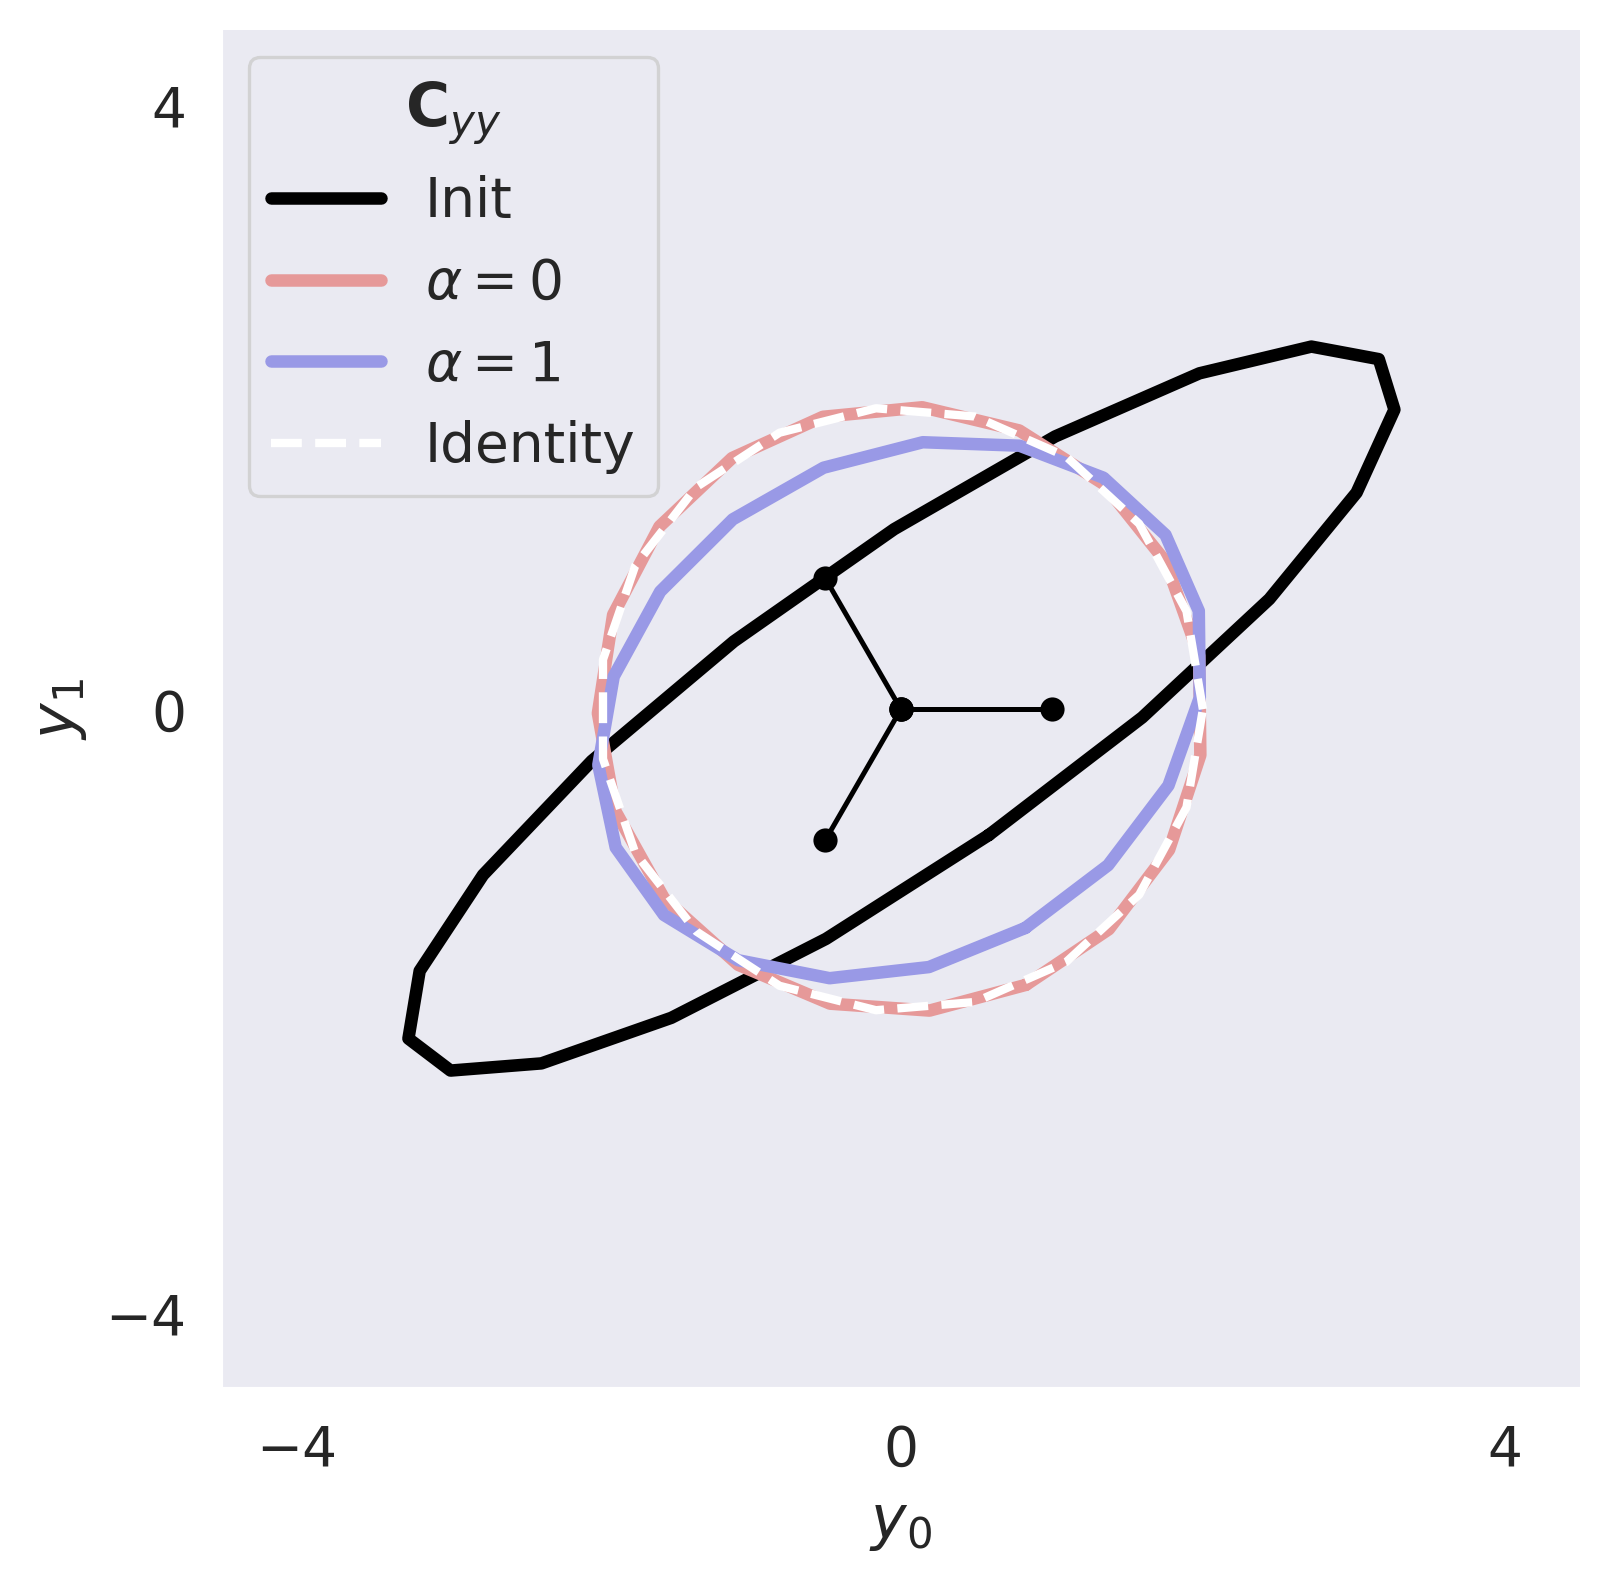

In [36]:
cols = sns.color_palette("mako", len(alphas))

# pink and purple
# fmt: off
cols = [(.9, 0.6, 0.6), (0.6, 0.6, .9)]
with sns.plotting_context("paper", font_scale=1.5):
    sns.set_style("dark")
    fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=300)
    M0 = np.linalg.inv(W @ np.diag(data[(FuncType.POWER, 0)][0].squeeze()) @ W.T)
    M1 = np.linalg.inv(W @ np.diag(data[(FuncType.POWER, 1)][0].squeeze() ** 2) @ W.T)
    fwplt.plot_ellipse(Cxx0, ax=ax, **{"color": "k", "linewidth": 3, "label": r"Init"})
    fwplt.plot_ellipse(
        M0 @ Cxx0 @ M0,
        ax=ax,
        **{"color": cols[0], "linewidth": 3, "label": r"$\alpha=0$"},
    )
    fwplt.plot_ellipse(
        M1 @ Cxx0 @ M1,
        ax=ax,
        **{"color": cols[1], "linewidth": 3, "label": r"$\alpha=1$"},
    )
    fwplt.plot_ellipse(
        np.eye(n),
        ax=ax,
        **{"color": "w", "linewidth": 2, "linestyle": "--", "label": "Identity"},
    )

    fwplt.plot_frame2d(W, ax=ax, color="k")
    ax.legend(title=r"${\bf C}_{yy}$")

    ax.axis("square")
    lims = 4.5
    ax.set(xlim=(-lims, lims), ylim=(-lims, lims), ylabel=r"$y_1$", xlabel=r"$y_0$",
    xticks=(-4, 0, 4), yticks=(-4, 0, 4))
    sns.despine()
# fmt: on

### Plot the convergence of g

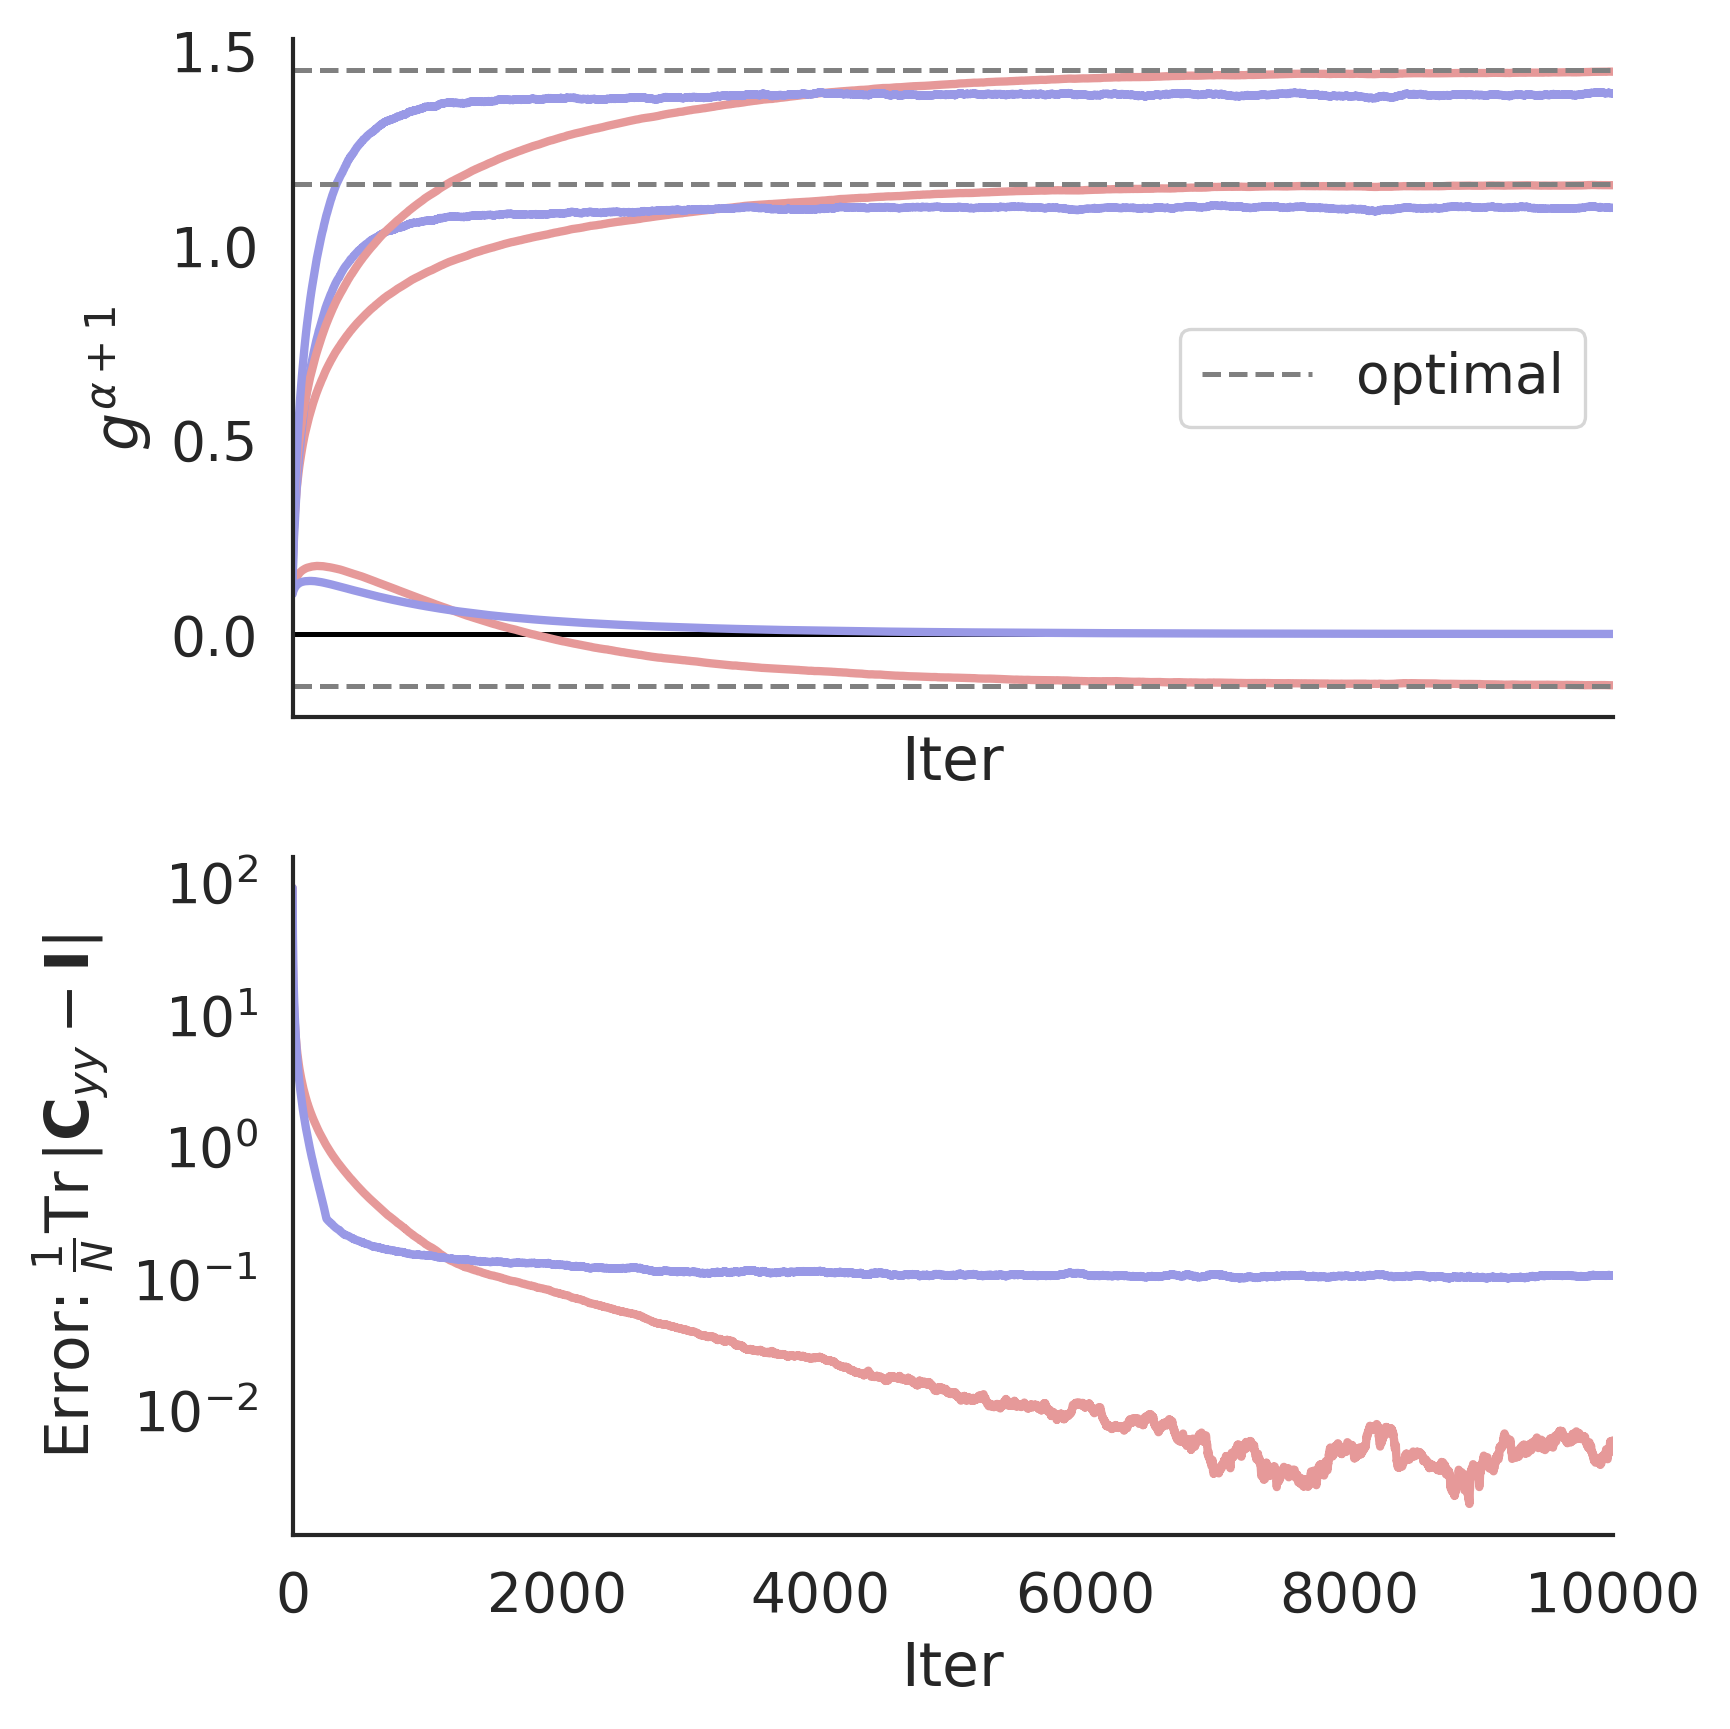

In [44]:
# fmt: off
with sns.plotting_context("paper", font_scale=1.5):
    sns.set_style("white")
    fig, ax = plt.subplots(2, 1, figsize=(6, 6), dpi=300, sharex="all")
    ax[0].set(
        xlim=(0, n_batch), ylabel=r"$g^{\alpha + 1}$", xlabel="Iter", yticks=np.arange(0,2,0.5),
    )
    ax[0].hlines(0, 0, n_batch, linestyle="-", color="k")
    
    for i in range(3):
        ax[0].plot(data[FuncType.POWER, 0][1][:,i], color=cols[0], linewidth=2)#, label=r"$\alpha=0$" if i == 0 else None)
        ax[0].plot(np.power(data[FuncType.POWER, 1][1][:,i], 2), color=cols[1], linewidth=2)#, label=r"$\alpha=1$" if i == 0 else None)

    ax[0].hlines(g_opt, 0, n_batch, linestyle="--", color="grey", label="optimal")
    ax[0].legend()
    sns.despine()

    for i, alpha in enumerate(range(2)):
        ax[1].plot(data[(FuncType.POWER, alpha)][-1], color=cols[i], label=r"$\alpha={}$".format(alpha), linewidth=2)
        ax[1].set(yscale='log', 
        ylabel=r'Error: $\frac{1}{N}\operatorname{Tr}\vert {\bf C}_{yy} - {\bf I} \vert$', 
        xlabel="Iter")

    sns.despine()
    fig.tight_layout()
# fmt: on